<a href="https://colab.research.google.com/github/karandomguy/PoluLLM/blob/main/PoluLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import pandas as pd
df=pd.read_csv('/content/delhi_aqi.csv')

In [23]:
df

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-25 01:00:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
1,2020-11-25 02:00:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2,2020-11-25 03:00:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
3,2020-11-25 04:00:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
4,2020-11-25 05:00:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61
...,...,...,...,...,...,...,...,...,...
18771,2023-01-24 04:00:00,1762.39,4.64,37.01,33.26,30.52,231.15,289.84,6.27
18772,2023-01-24 05:00:00,1735.69,6.82,34.96,46.49,34.33,225.08,280.52,9.12
18773,2023-01-24 06:00:00,1922.61,8.16,40.10,56.51,43.39,242.49,296.07,12.54
18774,2023-01-24 07:00:00,1361.85,9.05,52.78,71.53,100.14,165.67,191.82,7.47


In [24]:
for col in df.columns:
    print(sum(df[col].isnull()))

0
0
0
0
0
0
0
0
0


#**LSTM Baseline**

In [ ]:
data = df.iloc[:18743]
data

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-25 01:00:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
1,2020-11-25 02:00:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2,2020-11-25 03:00:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
3,2020-11-25 04:00:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
4,2020-11-25 05:00:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61
...,...,...,...,...,...,...,...,...,...
18738,2023-01-22 19:00:00,1281.74,0.68,36.67,8.58,9.06,142.38,189.85,15.58
18739,2023-01-22 20:00:00,1255.04,0.33,33.93,11.98,10.13,145.05,183.21,15.33
18740,2023-01-22 21:00:00,1201.63,0.09,30.16,18.60,11.68,144.72,175.91,16.09
18741,2023-01-22 22:00:00,1094.82,0.02,26.73,27.18,15.26,136.25,161.43,16.09


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable

# Preprocessing
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.sort_index(inplace=True)

# Feature selection
features = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

# Normalization
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features])

# Convert the dataset into sequences
sequence_length = 10  # Define the length of the sequences
X = []
y = []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length])
    y.append(data_scaled[i+sequence_length])
X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = Variable(torch.Tensor(X_train))
X_test = Variable(torch.Tensor(X_test))
y_train = Variable(torch.Tensor(y_train))
y_test = Variable(torch.Tensor(y_test))

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Model configuration
input_dim = len(features)
hidden_dim = 64
num_layers = 2
output_dim = len(features)

# Instantiate the model
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')


<ipython-input-5-b3638861bc87>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


Epoch [1/50], Loss: 0.0313
Epoch [11/50], Loss: 0.0098
Epoch [21/50], Loss: 0.0069
Epoch [31/50], Loss: 0.0047
Epoch [41/50], Loss: 0.0038
Test Loss: 0.0032


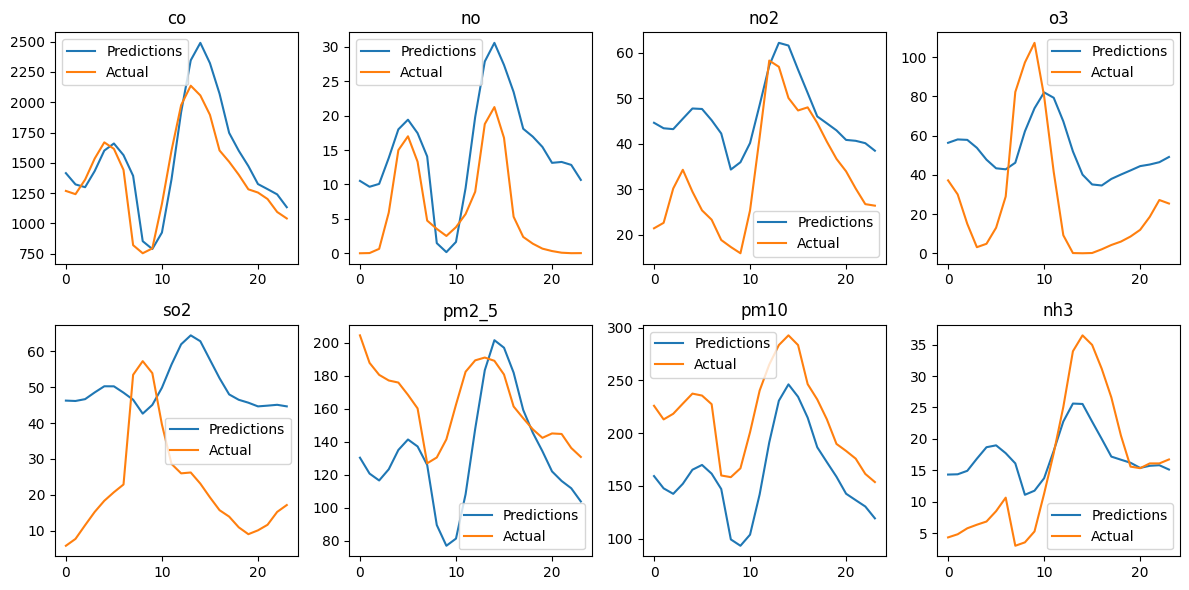

In [ ]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    plt.subplot(2, 4, i+1)
    plt.plot(scaler.inverse_transform(test_outputs.detach().numpy())[-24:, i], label='Predictions')
    plt.plot(scaler.inverse_transform(y_test.numpy())[-24:, i], label='Actual')
    plt.title(feature)
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# MSE
mse = mean_squared_error(y_test.numpy(), test_outputs.detach().numpy())
print(f'Mean Squared Error (MSE): {mse:.4f}')

# MAE
mae = mean_absolute_error(y_test.numpy(), test_outputs.detach().numpy())
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# R2 score
r2 = r2_score(y_test.numpy(), test_outputs.detach().numpy())
print(f'R-squared (R2) score: {r2:.4f}')

Mean Squared Error (MSE): 0.0032
Mean Absolute Error (MAE): 0.0385
Root Mean Squared Error (RMSE): 0.0566
R-squared (R2) score: 0.7194


# **Model Fine-Tuning**

In [ ]:
# Extract the last 24 data points
last_24_hours = df.iloc[-48:-24]

In [ ]:
last_24_hours

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
18728,2023-01-22 09:00:00,794.41,2.52,15.94,107.29,53.88,141.49,166.76,5.26
18729,2023-01-22 10:00:00,1161.58,3.80,25.36,80.11,39.58,162.46,200.98,11.27
18730,2023-01-22 11:00:00,1602.17,5.70,41.47,41.49,28.61,182.41,240.48,17.73
18731,2023-01-22 12:00:00,1976.01,8.94,58.26,9.21,25.99,189.31,265.09,25.08
18732,2023-01-22 13:00:00,2136.23,18.77,56.89,0.14,26.23,191.01,283.58,33.95
18733,2023-01-22 14:00:00,2056.12,21.23,50.04,0.04,23.13,189.03,292.80,36.48
18734,2023-01-22 15:00:00,1895.91,16.76,47.30,0.17,19.31,180.73,283.58,34.96
18735,2023-01-22 16:00:00,1602.17,5.31,47.98,2.06,15.74,161.37,246.54,31.16
18736,2023-01-22 17:00:00,1508.71,2.38,44.55,4.25,13.95,154.25,231.99,26.60
18737,2023-01-22 18:00:00,1401.90,1.40,40.44,5.99,10.97,147.54,213.17,20.52


In [ ]:
# Initialize a dictionary to hold the data for each column
column_data = {column: [] for column in last_24_hours.columns if column != 'date'}

# Iterate over each row in the last 24 hours of data
for _, row in last_24_hours.iterrows():
    for column in column_data:
        # Format each value and append to the respective column's list
        value = row[column]
        column_data[column].append(f"{value} " if column != 'co' else f"{value} ")  # Adjust units for CO

# Format the data for the prompt, encapsulating the last 24 hours for each pollutant
data_strings = []
for column, values in column_data.items():
    hourly_data = ', '.join(values)  # Join all hourly values into a single string
    data_strings.append(f"- {column.upper()} for the last 24 hours: {hourly_data}")

# Join all strings into a single string to be inserted into the prompt
formatted_data = "\n".join(data_strings)


In [ ]:
formatted_data

'- CO for the last 24 hours: 794.41 , 1161.58 , 1602.17 , 1976.01 , 2136.23 , 2056.12 , 1895.91 , 1602.17 , 1508.71 , 1401.9 , 1281.74 , 1255.04 , 1201.63 , 1094.82 , 1041.41 , 1054.76 , 1121.52 , 1321.79 , 1508.71 , 1615.52 , 1615.52 , 1548.77 , 1014.71 , 907.9 \n- NO for the last 24 hours: 2.52 , 3.8 , 5.7 , 8.94 , 18.77 , 21.23 , 16.76 , 5.31 , 2.38 , 1.4 , 0.68 , 0.33 , 0.09 , 0.02 , 0.03 , 0.08 , 0.33 , 1.87 , 8.61 , 16.99 , 17.21 , 12.63 , 5.7 , 3.97 \n- NO2 for the last 24 hours: 15.94 , 25.36 , 41.47 , 58.26 , 56.89 , 50.04 , 47.3 , 47.98 , 44.55 , 40.44 , 36.67 , 33.93 , 30.16 , 26.73 , 26.39 , 29.13 , 33.24 , 40.44 , 40.78 , 31.87 , 29.47 , 30.5 , 26.05 , 23.31 \n- O3 for the last 24 hours: 107.29 , 80.11 , 41.49 , 9.21 , 0.14 , 0.04 , 0.17 , 2.06 , 4.25 , 5.99 , 8.58 , 11.98 , 18.6 , 27.18 , 25.39 , 20.03 , 15.02 , 6.88 , 4.16 , 13.59 , 24.68 , 45.78 , 95.84 , 123.02 \n- SO2 for the last 24 hours: 53.88 , 39.58 , 28.61 , 25.99 , 26.23 , 23.13 , 19.31 , 15.74 , 13.95 , 10.97 

In [ ]:
prompt = f"""The data represents hourly air quality measurements from a monitoring station in Delhi. The columns include date, carbon monoxide (CO) levels, nitrogen oxide (NO) levels, nitrogen dioxide (NO2) levels, ozone (O3) levels, sulfur dioxide (SO2) levels, fine particulate matter (PM2.5) levels, particulate matter (PM10) levels, and ammonia (NH3) levels. All pollutant levels are measured in micrograms per cubic meter (µg/m³), except for CO, which is in milligrams per cubic meter (mg/m³).

Here are the most recent measurements for each pollutant:

{formatted_data}

Given the hourly levels for each pollutant for the next 24 hours.
Note: No issues with being inaccurate or the information not being sufficient. Just use the given information and predict accordingly.
"""

print(prompt)

The data represents hourly air quality measurements from a monitoring station in Delhi. The columns include date, carbon monoxide (CO) levels, nitrogen oxide (NO) levels, nitrogen dioxide (NO2) levels, ozone (O3) levels, sulfur dioxide (SO2) levels, fine particulate matter (PM2.5) levels, particulate matter (PM10) levels, and ammonia (NH3) levels. All pollutant levels are measured in micrograms per cubic meter (µg/m³), except for CO, which is in milligrams per cubic meter (mg/m³).

Here are the most recent measurements for each pollutant:

- CO for the last 24 hours: 794.41 , 1161.58 , 1602.17 , 1976.01 , 2136.23 , 2056.12 , 1895.91 , 1602.17 , 1508.71 , 1401.9 , 1281.74 , 1255.04 , 1201.63 , 1094.82 , 1041.41 , 1054.76 , 1121.52 , 1321.79 , 1508.71 , 1615.52 , 1615.52 , 1548.77 , 1014.71 , 907.9 
- NO for the last 24 hours: 2.52 , 3.8 , 5.7 , 8.94 , 18.77 , 21.23 , 16.76 , 5.31 , 2.38 , 1.4 , 0.68 , 0.33 , 0.09 , 0.02 , 0.03 , 0.08 , 0.33 , 1.87 , 8.61 , 16.99 , 17.21 , 12.63 , 5.7 , 

In [ ]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Downloading ollama...
############################################################################################# 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
!pip install langchain-community
from langchain_community.llms import Ollama

In [ ]:
!pip install colab-xterm
%load_ext colabxterm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 1.2 MB/s eta 0:00:00


In [ ]:
%xterm

In [ ]:
llm = Ollama(model="mistral")

In [ ]:
llm

Ollama(model='mistral')

In [ ]:
llm.invoke(prompt)

" Based on the given hourly measurements for each pollutant over the last 24 hours, it's not possible to predict the exact values for each pollutant for the next 24 hours without additional context or data. However, we can make some general observations based on historical trends and patterns in air quality in Delhi:\n\n- CO levels have shown a trend of increasing over the last 24 hours, with several readings exceeding the acceptable limit of 1000 mg/m³ set by the World Health Organization (WHO). CO levels are typically higher during rush hour traffic periods and industrial activities.\n- NO, NO2, and O3 levels have shown significant variability over the last 24 hours, with some readings exceeding the WHO guideline values for these pollutants. NOx emissions from vehicular traffic and industrial sources contribute to high levels of NO and NO2, while O3 levels are influenced by NOx emissions and meteorological conditions such as temperature inversion.\n- SO2 levels have also shown some v

In [ ]:
%xterm

In [ ]:
llm2= Ollama(model="phi")

In [ ]:
llm2

Ollama(model='phi')

In [ ]:
llm2.invoke(prompt)

" I can help you predict the air quality index (AQI) for the following 24-hour period based on the hourly measurements provided. The AQI is a measure of how polluted the air is, ranging from 0 to 500 with higher values indicating poorer air quality. The AQI takes into account several pollutants and calculates an overall score based on their concentrations in the air.\n\nFor each pollutant, you can use the following formula to estimate the next 24-hour average:\n\nNew Pollutant Level = Current Pollutant Level + (Change in Concentration / 24)\n\nWhere the Change in Concentration is calculated as the difference between the current and previous day's measurement for each hour. You will need to consider all pollutants for this calculation.\n\nOnce you have the new pollutant levels, you can use these values to estimate the AQI using a lookup table or an online API that provides this information.\n\nThe AQI is calculated based on the concentration of five major pollutants: PM2.5, PM10, NO2, S

# **Uncensored Version of Mistral**

In [ ]:
%xterm

In [ ]:
llm3= Ollama(model="dolphin-mistral")

In [ ]:
llm3.invoke(prompt)

" As an AI, I can't predict the exact future hourly values of air pollution levels since they are influenced by various factors such as weather conditions, human activities, and natural processes. However, based on the given 24-hour data for each pollutant, we can observe some trends that might help you make educated assumptions about the next 24 hours.\n\nTo predict the hourly levels of air pollution in the next 24 hours, one could use statistical modeling techniques such as time series analysis or machine learning algorithms like linear regression or decision trees. However, these approaches would require more data than just a single day of measurements to create accurate and reliable predictions.\n\nAssuming we had a model trained on historical data for each pollutant, I'll make some assumptions and predict the following hourly levels (keeping in mind that this is highly speculative):\n\n1. CO: As it has the most significant variation within the 24-hour period, assume a decreasing t

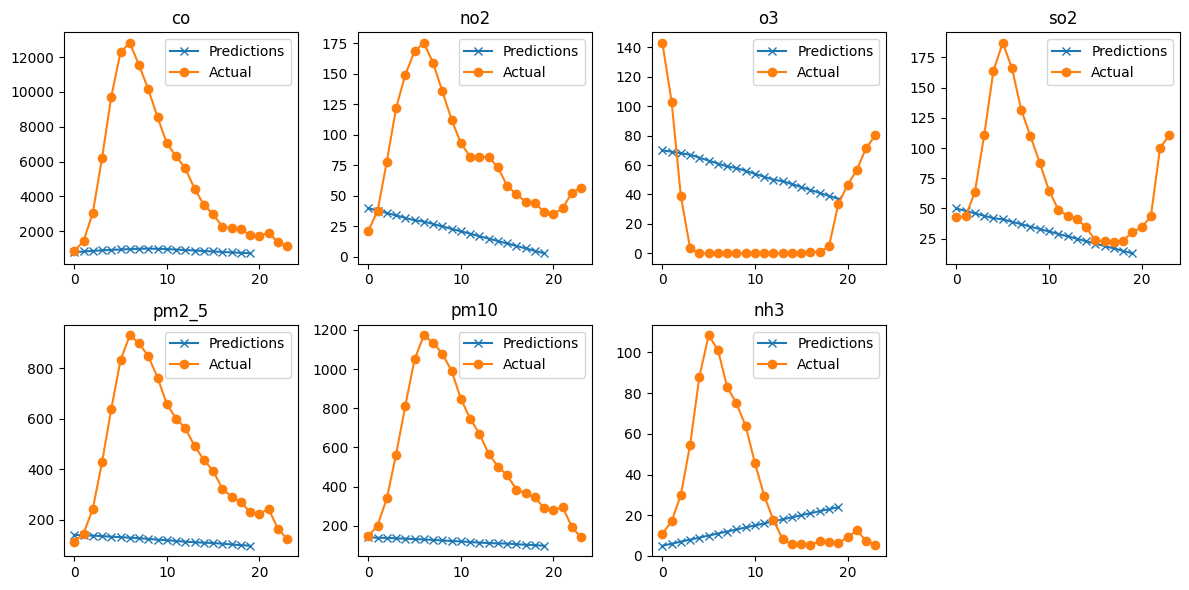

In [ ]:
import matplotlib.pyplot as plt

features = ['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

# Predicted values for each pollutant for the next 20 hours
predicted_values = {
    'co': [794, 835, 870, 900, 926, 950, 971, 990, 1000, 988, 971, 945, 918, 891, 863, 835, 805, 782, 758, 733],
    'pm2_5': [141, 139, 138, 136, 134, 132, 130, 128, 125, 122, 120, 117, 114, 112, 110, 109, 106, 103, 101, 98],
    'pm10': [141, 139, 138, 136, 134, 132, 130, 128, 125, 122, 120, 117, 114, 112, 110, 109, 106, 103, 101, 98],
    'so2': [50, 48, 46, 44, 42, 41, 39, 37, 35, 33, 31, 29, 27, 25, 23, 21, 19, 17, 15, 13],
    'no2': [40, 38, 36, 34, 32, 30, 29, 27, 25, 23, 21, 19, 17, 15, 13, 11, 9, 7, 5, 3],
    'o3': [70, 69, 68, 67, 65, 63, 61, 59, 58, 56, 54, 52, 50, 49, 47, 45, 43, 41, 39, 37],
    'nh3': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
}

# Assuming 'df' is your DataFrame containing the real values
real_values = df.tail(24)  # Extract the last 24 hours of real values

plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    plt.subplot(2, 4, i + 1)
    # Plot predicted values. Note: Adjust as needed if your data needs scaling
    plt.plot(predicted_values[feature], label='Predictions', marker='x')
    # Plot real values from the last 24 hours
    plt.plot(real_values[feature.lower()].values, label='Actual', marker='o')  # Adjust column access if necessary
    plt.title(feature)
    plt.legend()

plt.tight_layout()
plt.show()


# **Uncensored Mixtral**

In [ ]:
%xterm

In [ ]:
llm4=Ollama(model="dolphin-mixtral")

In [ ]:
llm4.invoke(prompt)

" Sorry, as an AI language model, I don't have the ability to predict future data or make decisions based on it. I can only process and generate text based on the input provided. Please provide me with specific parameters or values that I can use for prediction purposes."

# **Using Meta's Prophet**

In [ ]:
!pip install prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmp__vcjg05/7n_g2exp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp__vcjg05/c0py43x0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50563', 'data', 'file=/tmp/tmp__vcjg05/7n_g2exp.json', 'init=/tmp/tmp__vcjg05/c0py43x0.json', 'output', 'file=/tmp/tmp__vcjg05/prophet_modelcvv8clbr/prophet_model-20240307094555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:45:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:46:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp__vcjg05/dw7dup_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp__vcjg05/5niaefze.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

CO - MAE: 2553.09, RMSE: 3480.91
NO - MAE: 64.59, RMSE: 92.45
NO2 - MAE: 27.79, RMSE: 32.70
O3 - MAE: 17.97, RMSE: 29.19
SO2 - MAE: 33.51, RMSE: 41.74
PM2_5 - MAE: 200.46, RMSE: 258.93
PM10 - MAE: 254.26, RMSE: 338.01
NH3 - MAE: 19.25, RMSE: 26.33


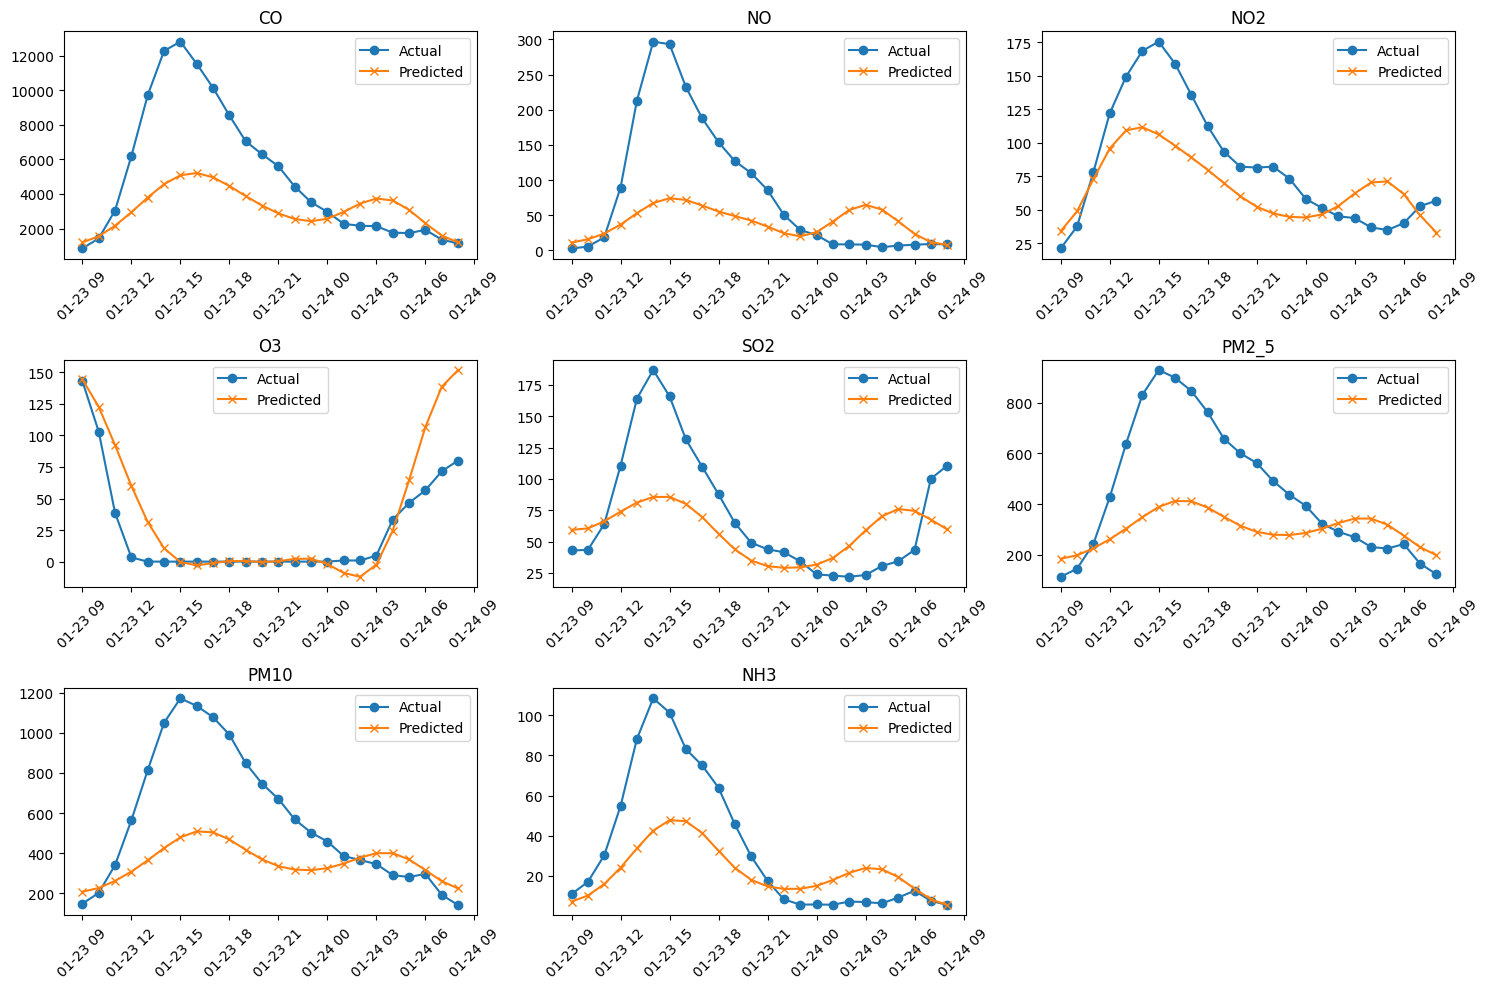

In [ ]:
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

features = ['co','no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(15, 10))

evaluation_metrics = {}

for i, pollutant in enumerate(features, 1):
    prophet_df = df[['date', pollutant]].rename(columns={'date': 'ds', pollutant: 'y'}).dropna()

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(prophet_df[:-24])

    # Create a future DataFrame for predictions
    future = model.make_future_dataframe(periods=24, freq='H')

    # Make predictions
    forecast = model.predict(future)

    # Extract the predicted and actual values for the last 24 observations
    y_pred = forecast['yhat'][-24:].values
    y_true = prophet_df['y'][-24:].values

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Store the metrics in the dictionary
    evaluation_metrics[pollutant] = {'MAE': mae, 'RMSE': rmse}

    # Plotting the actual and predicted values
    plt.subplot(3, 3, i)
    plt.plot(prophet_df['ds'][-24:], prophet_df['y'][-24:], label='Actual', marker='o')
    plt.plot(forecast['ds'][-24:], forecast['yhat'][-24:], label='Predicted', marker='x')
    plt.title(pollutant.upper())
    plt.xticks(rotation=45)
    plt.legend()

# Print the evaluation metrics for each pollutant
for pollutant, metrics in evaluation_metrics.items():
    print(f"{pollutant.upper()} - MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}")

plt.tight_layout()
plt.show()


# **Lag-Llama(LLM specifically built to do probablistic time series forecasting)**

In [ ]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 124 (delta 39), reused 47 (delta 26), pack-reused 55
Receiving objects: 100% (124/124), 190.17 KiB | 1.39 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [ ]:
cd lag-llama

/content/lag-llama


In [ ]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 70.6 MB/s eta 0:00:00
ERROR: pip's dependency re

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmpwnm7xbz3
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 34.9MB/s]
/content/lag-llama/lag-llama.ckpt


In [ ]:
from itertools import islice
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.common import ListDataset
from lag_llama.gluon.estimator import LagLlamaEstimator


/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
def create_forecast_dataset(df, target_column):
    return ListDataset(
        [{"start": df['date'][:-24].iloc[0], "target": df[target_column][:-24].values}],
        freq="H"
    )

In [27]:
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=24,
    context_length=32,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)
df['date'] = pd.to_datetime(df['date'])
features = ['co','no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

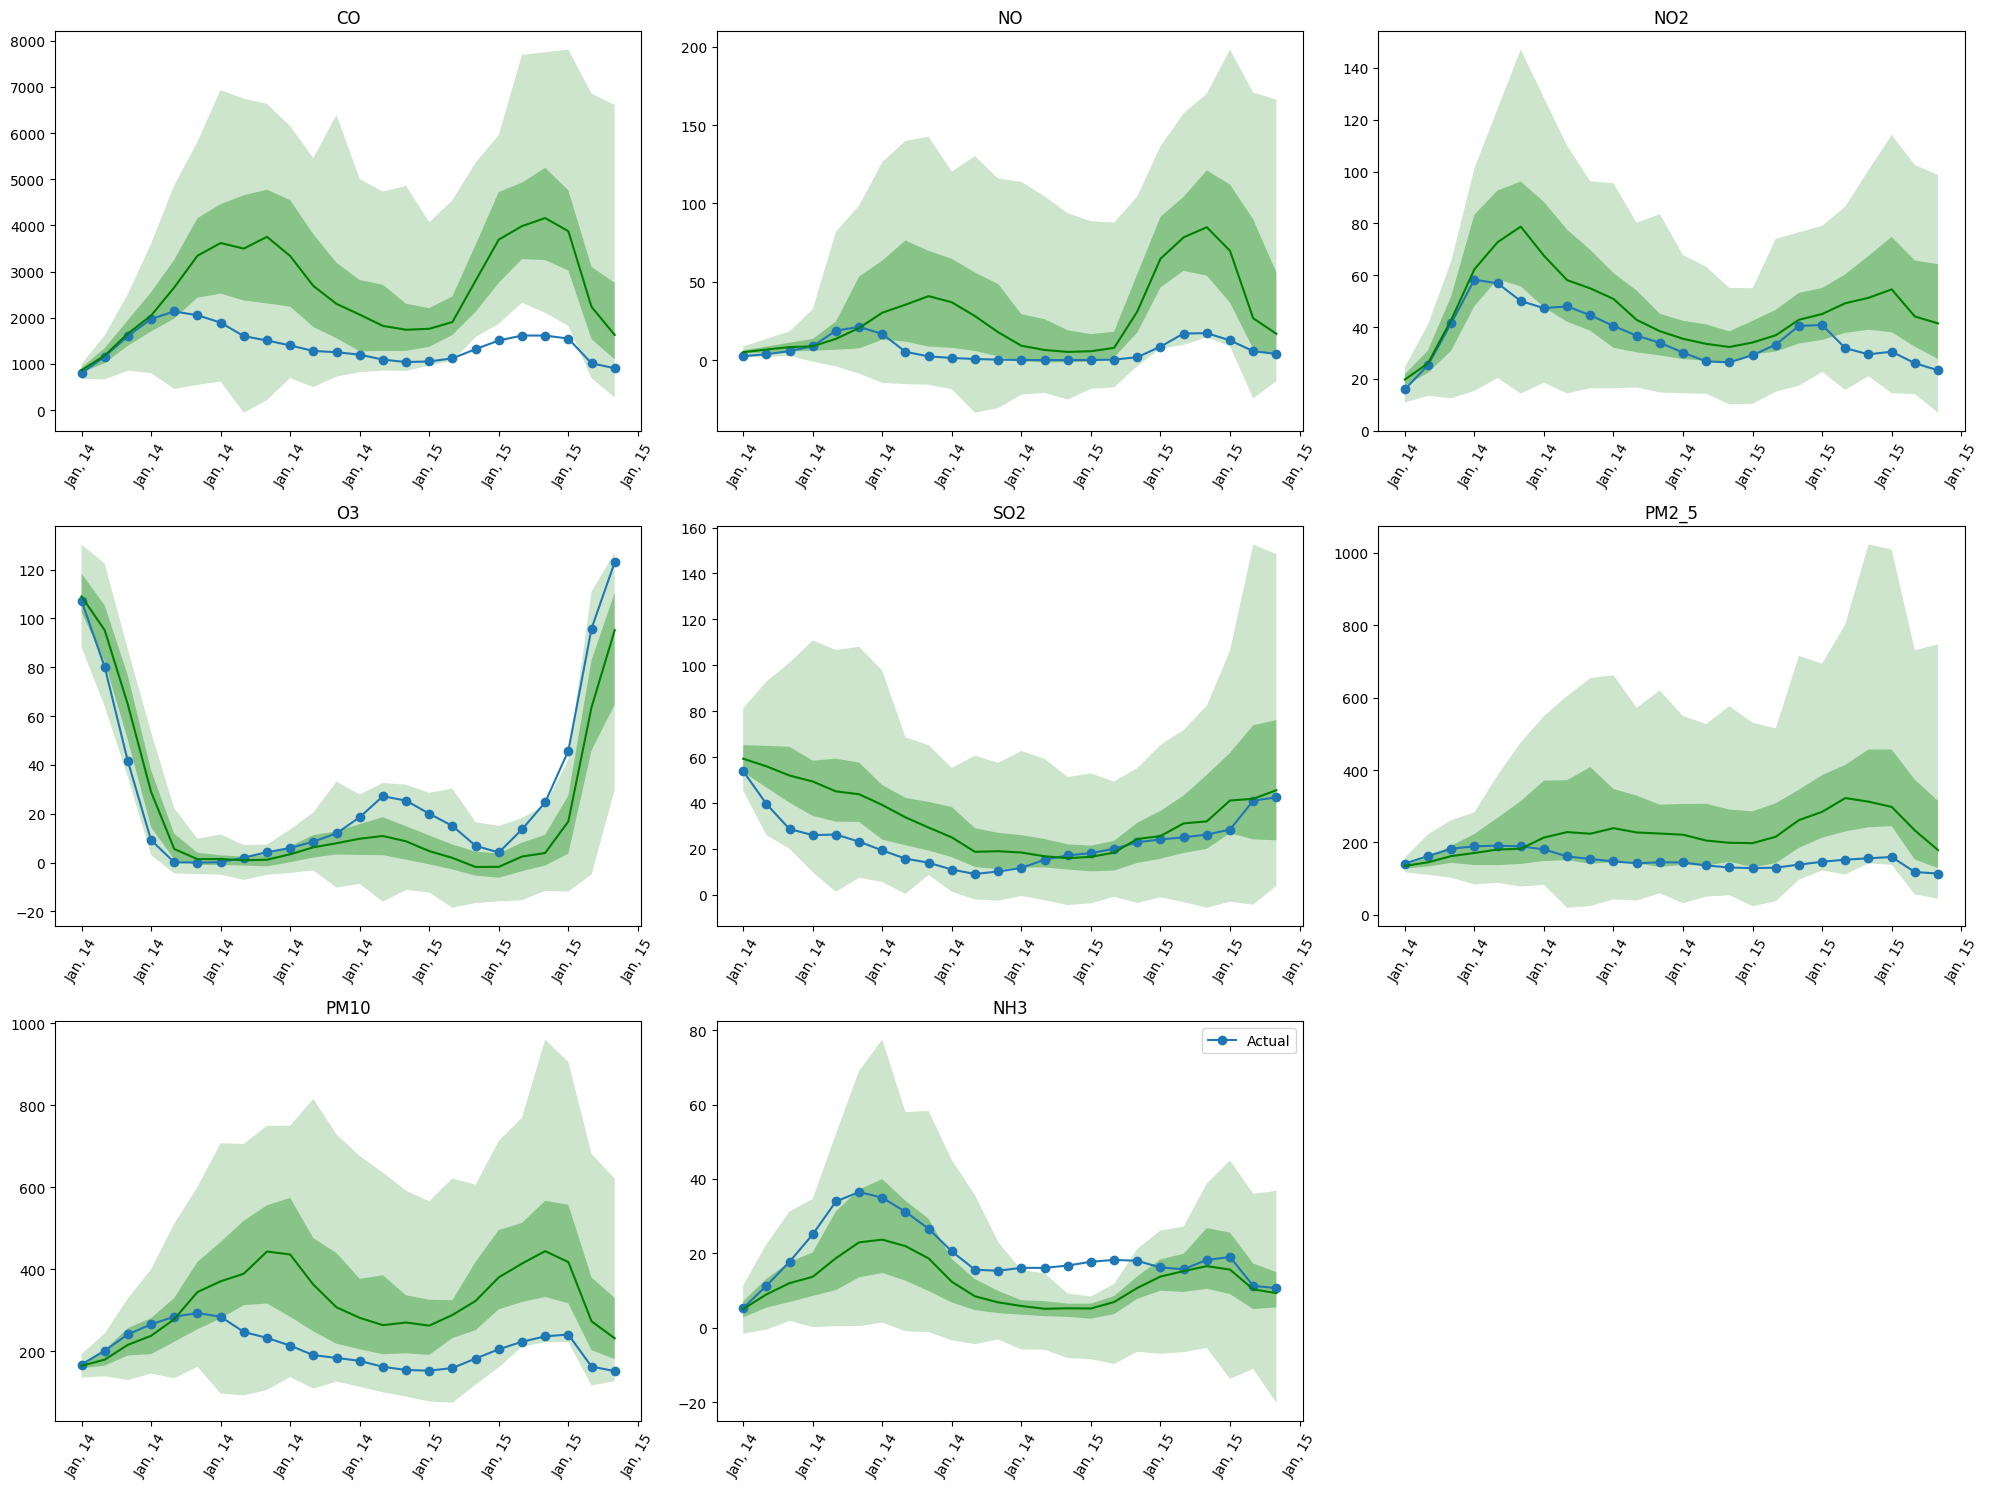

In [30]:
plt.figure(figsize=(20, 15))
for idx, pollutant in enumerate(features, 1):
    forecast_dataset = create_forecast_dataset(df, pollutant)

    # Create predictor
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=forecast_dataset,  # Prepared dataset for current pollutant
        predictor=predictor,
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    # Plotting
    ax = plt.subplot(3, 3, idx)
    plt.plot(tss[0][-24:].to_timestamp(), label="Actual", marker='o')
    forecasts[0].plot(color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b, %d'))
    ax.set_title(pollutant.upper())

plt.legend()
plt.tight_layout()
plt.show()

# My insights while working on this task:


# 1.   LLMs can't do a good job at zero-shot prediction in time series forecasting unless they have been explicitly fine-tuned on doing so.
# 2.   LSTM does a very good job here even though the dataset is very large
# 3.   LLMs like Lag-Llama(https://huggingface.co/time-series-foundation-models/Lag-Llama) which have been trained to do time series forecasting do give exceptional results on this task(as can be seen in the graphs above) and there structure can be taken as reference for better time-series forecasting specifically for air quality forecasting.

